In [1]:
%matplotlib inline
from utils import *
from pycaret.regression import*
from sklearn.metrics import mean_squared_error


In [10]:
class DATA(object):
    # ----------------------------------------------------------------------------------------    
    def __init__(self, dataset_name, target, features):        
        self.X, self.Y = list(), list()        
        folder_path = os.path.dirname( get_dataset_file_path(dataset_name,'') )        
        for file_path in list(Path(folder_path).glob('*.pkl')):        
            data = pd.read_pickle( file_path )   
            x_list, names = list(), list()            
            for feature in features:
                x_n = data.filter(regex=feature, axis=1)
                x_list.append(x_n)
                names = [*names, *x_n.columns]            
            x = pd.concat(x_list, axis=1, ignore_index=True)
            x.columns = names 
            y = data.filter(regex=target, axis=1).rename({target:'target'}, axis=1)            
            self.X.append(x)
            self.Y.append(y)                
        return       
    # ----------------------------------------------------------------------------------------
    def get_data(self, win_size=None, step=None, features=False, as_mtx=True):        
        if win_size is not None and step is None: step = win_size

        dataset = list()              
        for x,y in zip(self.X, self.Y):  
            if win_size is not None:
                y = pd.DataFrame({'target':[y.loc[i+win_size-1, 'target'] for i in range(0, len(y)-win_size, step)]})               
                if features:                
                    x = np.array([get_features_win(x.loc[i:i+win_size,:].values) for i in range(0, len(x)-win_size, step)]) 
                else:
                    x = np.array([x.loc[i:i+win_size,:].values.reshape(1,-1) for i in range(0, len(x)-win_size, step)])
                x = x.reshape(np.shape(x)[0], np.shape(x)[2])
                x = pd.DataFrame(x)
                x.columns = ["{0:0=2d}".format(n) for n in range(np.shape(x)[1])] 
                print(x)
            dataset.append( pd.concat([y, x], axis=1) ) 
            
        if as_mtx:
            return pd.concat(dataset, axis=0, ignore_index=True)
        
        return dataset
# --------------------------------------------------------------------------------------------


# # --------------------------------------------------------------------------------------------
# def segment(x, y, win_size, step):
#     y = pd.DataFrame('target':[y.loc[i+win_size-1].vlues for i in range(0, len(y)-win_size, step)] )               
#     if features:
#         x = np.array([x.loc[i:i+win_size,:].values.reshape(1,-1) for i in range(0, len(x)-win_size, step)])
#     else:
#         x = np.array([get_features_win(x.loc[i:i+win_size,:].values) for i in range(0, len(x)-win_size, step)]) 
#         x = x.reshape(np.shape(x)[0], np.shape(x)[2])
    
#     x = pd.DataFrame(x)
#     x.columns = ["{0:0=2d}".format(n) for n in range(size(x,1))] 
#     return x, y
# # --------------------------------------------------------------------------------------------
def get_features_win( x_t ):
    axis = 0
    x_f = np.real( np.fft.fft(x_t, axis=axis) )
    x_wA, x_wD = pywt.dwt(x_t, 'db1', axis=axis)
    dx_t = np.diff( x_t, axis=axis )
    
    features = list()
    for x_ in [x_t, x_f, x_wA, x_wD, dx_t]:     
        feature = list()  
        feature.append( np.mean( x_, axis=axis )) 
        feature.append( np.std( x_, axis=axis ))                               
        feature.append( np.median( x_, axis=axis ))               
        feature.append( np.min( x_, axis=axis ))               
        feature.append( np.max( x_, axis=axis ))               
        feature.append( np.var( x_, axis=axis ))               
        feature.append( np.percentile( x_, 25, axis=axis ))               
        feature.append( np.percentile( x_, 75, axis=axis ))               
        feature.append( stats.skew( x_, axis=axis))               
        feature.append( stats.kurtosis( x_, axis=axis))               
        feature.append( stats.iqr( x_, axis=axis))               
        feature.append( np.sqrt(np.mean(np.power(x_,2), axis=axis)))               
        
        feature = np.array(feature).transpose()
        features.append(feature)
        
    return np.concatenate(features, axis=1).reshape(1,-1)
# # --------------------------------------------------------------------------------------------
# def segment_(x, y, win_size, step):    
#     x_segmented, y_segmented = pd.DataFrame(), pd.DataFrame()
#     for i in range(0, len(x)- win_size, step):
#         y_segmented = y_segmented.append(y.loc[i+win_size-1], ignore_index=True)
#         row = dict()
#         for x_name in x.columns: 
#             for j in range(win_size): row.update({ x_name + "{0:0=2d}".format(j): x.loc[i+j, x_name] })        
#         x_segmented = x_segmented.append(row, ignore_index=True)
#     return x_segmented, y_segmented


#### Load Data

In [11]:
target = 'distance_1'
features = ['rssi, status'] 

train_data = DATA('dataset_02', target, features)
validation_data = DATA('dataset_03', target, features)

In [12]:
train_data.X[0]

""
0
1
2
3
4
...
516
517
518
519


# Regression

#### Sliding Window

In [34]:
win_size = 20
step = 1

train_data_segmented = train_data.get_data(win_size=win_size, step=step)
validation_data_segmented = validation_data.get_data(win_size=win_size, step=step, as_mtx=False)

In [38]:
train_data.X[0]

""
0
1
2
3
4
...
516
517
518
519


#### Setup

In [18]:
exp_reg = setup(train_data_segmented,
                train_size = .8,
                target = 'target', 
#                 normalize = True, 
#                 silent = True,
                session_id = 20
                )   

 
Setup Succesfully Completed!


,Description,Value
0,session_id,20
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(14542, 43)"
4,Missing Values,False
5,Numeric Features,42
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


#### Model

In [19]:
model = tune_model('rf')
# model = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0492,0.0039,0.0621,0.3636,0.0471,0.1672
1,0.0486,0.0040,0.0631,0.3593,0.0475,0.1592
2,0.0491,0.0041,0.0638,0.3675,0.0480,0.1619
3,0.0493,0.0040,0.0634,0.3896,0.0479,0.1648
4,0.0490,0.0043,0.0655,0.3553,0.0496,0.1682
5,0.0494,0.0041,0.0643,0.3755,0.0490,0.1735
6,0.0498,0.0042,0.0645,0.3314,0.0487,0.1663
7,0.0505,0.0042,0.0646,0.3774,0.0487,0.1699
8,0.0502,0.0042,0.0649,0.3709,0.0490,0.1692
9,0.0483,0.0040,0.0632,0.3745,0.0478,0.1640


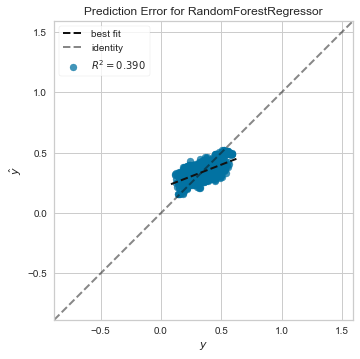

In [20]:
plot_model(model, plot='error')
# plot_model(model, plot='feature')

#### Validation

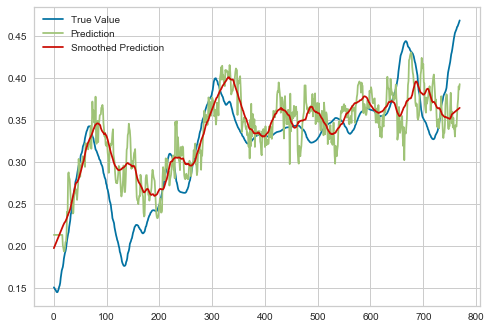

In [32]:
prediction = predict_model(model, data=validation_data_segmented[3])
smoothed_pred = signal.savgol_filter( prediction.Label, window_length=31, polyorder=1)  

ax = prediction.plot(y='target', legend=False)
prediction.plot(y='Label', ax=ax)
plt.plot(smoothed_pred)
plt.legend(['True Value', 'Prediction', 'Smoothed Prediction'])
plt.show()

In [23]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest,0.045000,0.003600,0.059600,0.504800,0.045300,0.157200
1,Extra Trees Regressor,0.045300,0.003600,0.060400,0.491700,0.045900,0.158300
2,CatBoost Regressor,0.047700,0.003800,0.061300,0.476100,0.046600,0.167400
3,Light Gradient Boosting Machine,0.048200,0.003800,0.062000,0.464700,0.047000,0.167600
4,K Neighbors Regressor,0.049100,0.004200,0.064700,0.415800,0.049200,0.173500
5,Extreme Gradient Boosting,0.051100,0.004300,0.065200,0.407300,0.049500,0.178900
6,Gradient Boosting Regressor,0.051100,0.004300,0.065200,0.406600,0.049500,0.178900
7,Support Vector Machine,0.055600,0.004900,0.069600,0.323300,0.052800,0.193600
8,AdaBoost Regressor,0.056100,0.004900,0.070300,0.311400,0.053300,0.197000
9,Bayesian Ridge,0.061500,0.005800,0.076300,0.189200,0.057900,0.218900


In [ ]:
# save_experiment(get_result_file_path('res_00'))

In [4]:
filepath = get_result_file_path('/'+'gbr'+'/' + str(10) + '_' + str(15) )
filepath

'C:\\Users\\mixil\\Desktop\\MIHAR_Hardware\\experiments/results//gbr/10_15'

# Grid Search

In [6]:
def grid_search( data, model_name, win_size_range, step_range ):
    for win_size in win_size_range:
        for step in step_range:
            if type(step) is float: step = max(1, int(step*win_size))
            if step is None: step = win_size
                
            filepath = get_result_file_path('/'+model_name+'/' + str(win_size) + '_' + str(step) )
            if os.path.isfile(filepath + '.pkl'): continue
            try:
                train_data = data.get_data(idxs_list=np.arange(5,30), win_size=win_size, step=step)
                exp_reg = setup(train_data,
                                train_size = .8,
                                target = 'target', 
                                session_id = 20,
                                silent = True
                                )
                model = tune_model(model_name)
                save_model(model, filepath)
            except:
                continue    
    return

In [ ]:
grid_search( data, 
            'gbr', 
            win_size_range = np.arange(1,20), 
            step_range =  [.2, .5, .75, None] )

# Comparison

In [48]:
def evaluate_saved_models( data, model_name, win_size, step, smoothing_win_size_range=np.arange(15) ):
    if type(step) is float: step = max(1, int(step*win_size))
    if step is None: step = win_size    
    
    smoothing_win_size_range = smoothing_win_size_range[smoothing_win_size_range>1]
    smoothing_win_size_range = smoothing_win_size_range[ (smoothing_win_size_range%2) == 1]

    filepath = get_result_file_path('/'+model_name+'/' + str(win_size) + '_' + str(step) )
    if os.path.isfile(filepath + '.pkl'): 
        test_data = data.get_data(idxs_list=[0], win_size=win_size, step=step)        
        model = load_model(filepath)
        prediction = predict_model(model, data=test_data)
        target = prediction.target.to_numpy()
        pred = prediction.Label.to_numpy()
        rmse =  mean_squared_error( target, pred )

        results = list()
        for smoothing_win_size in smoothing_win_size_range:
            smoothed_pred = signal.savgol_filter( pred, window_length=smoothing_win_size, polyorder=1)   
            smoothed_rmse =  mean_squared_error( target, smoothed_pred ) 
            results.append((smoothed_rmse, smoothed_pred, smoothing_win_size))                
        
        smoothed_rmse, smoothed_pred, smoothing_win_size = sorted(results, key=lambda x: x[0])[0]
        
        return rmse, smoothed_rmse, target, pred, smoothed_pred, win_size, step, smoothing_win_size
    
    return None

In [49]:
model_name = 'gbr'

results = list()
for win_size in range(10):
    for step in [.2, .5, .75, None]:
        best_result = evaluate_saved_models( data, model_name, win_size, step, smoothing_win_size_range=np.arange(15) )
        if best_result is not None:
            results.append(best_result)                

NRMSE= 14.4


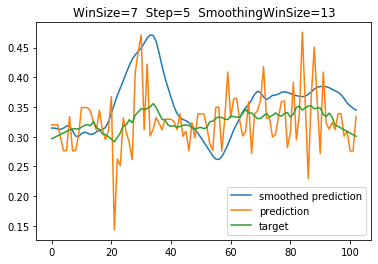

NRMSE= 15.37


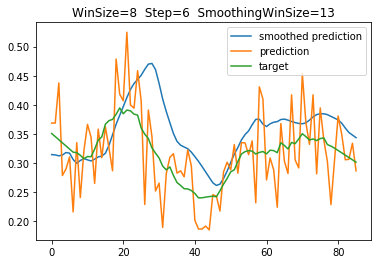

NRMSE= 16.03


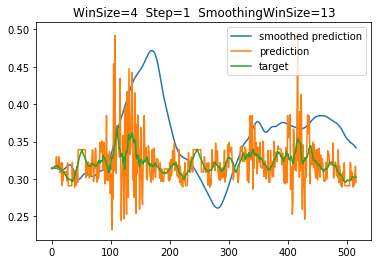

NRMSE= 16.27


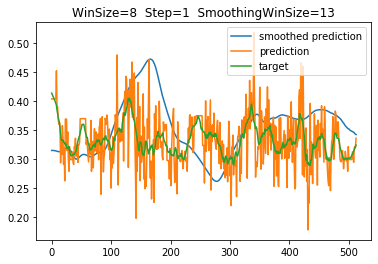

NRMSE= 16.33


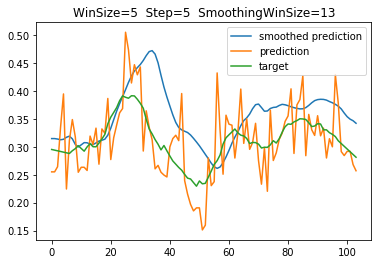

In [50]:
best_results = sorted(results, key=lambda x: x[1])

for res in best_results[:5]:
    rmse, smoothed_rmse, target, pred, smoothed_pred, win_size, step, smoothing_win = res

    plt.plot(target)
    plt.plot(pred)
    plt.plot(smoothed_pred)
    plt.legend({'target','prediction','smoothed prediction'})
    plt.title( 'WinSize='+str(win_size) + '  Step='+str(step) + '  SmoothingWinSize='+str(smoothing_win) )
    print( 'NRMSE=', round(smoothed_rmse**0.5 / np.mean(target) *100, 2) )
    plt.show()            

# sklearn

In [ ]:
from sklearn import*
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingRegressor
>>> reg = GradientBoostingRegressor(random_state=0)
>>> reg.fit(X_train, y_train)
GradientBoostingRegressor(random_state=0)
>>> reg.predict(X_test[1:2])
array([-61...])
>>> reg.score(X_test, y_test)


In [50]:
X_train = data.filter(regex='rssi', axis=1).to_numpy()
Y_train = data.filter(regex='target', axis=1).to_numpy()

model = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
model.fit(X_train, Y_train)



Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2,
                     gamma='scale', kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

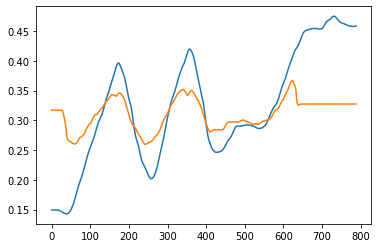

In [55]:
data_unseen = get_data( dataset_name, [29], target, features, win_size=win_size, step_size_ratio=step_size_ratio )

X_validation = data_unseen.filter(regex='rssi', axis=1).to_numpy()
Y_validation = data_unseen.filter(regex='target', axis=1).to_numpy()

predictions = model.predict( X_validation )  

plt.plot(Y_validation)
plt.plot(predictions)
plt.show()